In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm 
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from scipy.interpolate import interp1d
import os
import glob
from labellines import *
import math
from PIL import Image

divergent=LinearSegmentedColormap.from_list('divergent', (
    # Edit this gradient at https://eltos.github.io/gradient/#0D7D87-99C6CC-FBFBFB-EE9093-C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.250, (0.600, 0.776, 0.800)),
    (0.500, (0.984, 0.984, 0.984)),
    (0.750, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))

my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:0D7D87-20.8:99C6CC-40:B6B66B-60:F47A00-80:EE9093-100:C31E23
    (0.000, (0.051, 0.490, 0.529)),
    (0.208, (0.600, 0.776, 0.800)),
    (0.400, (0.714, 0.714, 0.420)),
    (0.600, (0.957, 0.478, 0.000)),
    (0.800, (0.933, 0.565, 0.576)),
    (1.000, (0.765, 0.118, 0.137))))
#Formatting for plots
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')
# DiscModel is in a different file
from src.DiscModel import DiscGalaxy
N = 1000000 # number of stars in the disc
a = 1 # a is the scale length of the disc in kpc
D = DiscGalaxy(N=N,a=a)

rmax = 212.
nbins = 64
mmax = 10
nmax = 10

noise = 0.5

"""Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes."""

'Recall m corresponds to Fourier (azimuthal) modes, n corresponds to Laguerre (radial harmonics) modes.'

Image size: 424x424 pixels


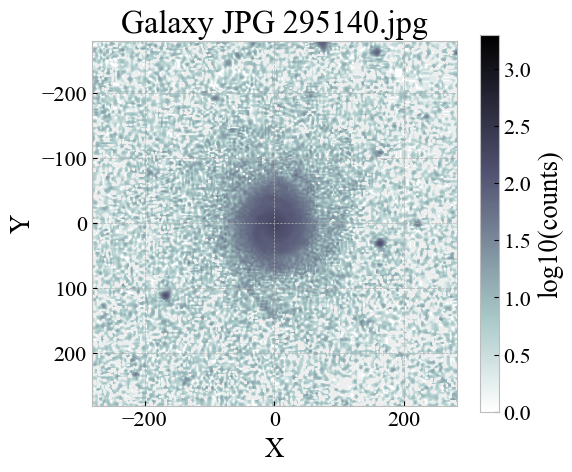

Amn (rows = n, columns = m):
[[4024.711  173.56   103.205   31.224   41.836   24.494   30.636   15.886
    20.608   16.016   21.142]
 [1796.103   58.171  245.888   49.754   96.884    6.757   16.564   27.753
    19.864   38.439   41.873]
 [ 338.915   11.359  186.244   36.446   82.574   62.794   37.5     17.167
    49.921   30.757   31.452]
 [ 301.815   59.286  112.642   59.844   33.836   37.849   12.481   49.137
    39.991   35.512   16.17 ]
 [ 698.413   31.075   32.074   53.387   92.356   21.519   64.906   26.103
    65.263   38.343   44.542]
 [ 401.252   45.732   99.146   65.005   93.636   46.797   81.261    5.371
    65.993   27.178   48.603]
 [ 338.54    60.669   66.223   53.45   194.969   68.023   26.377   26.228
    17.756   30.638   29.917]
 [ 377.544   36.912   95.823   53.315   67.468   36.59    70.574   37.209
    50.711   19.15    42.072]
 [  70.53    38.192   66.328   44.193  215.569   38.306   31.616   39.155
   105.504   55.852   33.232]
 [  23.461   44.409   61.372   46.4

Processing inclinations:   0%|          | 0/8 [00:18<?, ?inclination/s]


KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>

In [2]:
file="295140.jpg"  # replace with your image file
rmax = 281  # radius in pixels, adjust as needed
img_pil = Image.open(file).convert("L")
w, h    = img_pil.size
print(f"Image size: {w}x{h} pixels")
img_incl = np.array(img_pil, dtype=float)

x_edges = np.linspace(-rmax, rmax, w)
y_edges = np.linspace(rmax, -rmax, h)

safe     = np.where(img_incl>0, img_incl, np.nan)
log_img  = np.log10(safe)

plt.figure(figsize=(6,5))
plt.imshow(
    log_img, cmap="bone_r",
    extent=[x_edges[0],x_edges[-1],y_edges[0],y_edges[-1]],
    vmin=0, vmax=3.3
)
plt.colorbar(label="log10(counts)")
plt.title(f"Galaxy JPG {file}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

D = DiscGalaxy(N=N, a=a)
D.img     = img_incl
D.x_edges = x_edges
D.y_edges = y_edges
D.x_centers = x_edges
D.y_centers = y_edges


E1 = D.make_expansion(mmax, nmax, 20, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)



coscoefstrue = E1.coscoefs
sincoefstrue = E1.sincoefs

Amn = np.sqrt(coscoefstrue**2 +sincoefstrue**2) 

Amn_matrix = Amn.T 

print("Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,3)) 


# the grid of inclinations to draw curves for:
incl_list = np.linspace(10, 80, 8)     # eight sample inclinations
PA_list   = np.linspace(0, 180, 20)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))

i=0

for inc in tqdm(incl_list, desc="Processing inclinations", unit="inclination"):
    etas      = []
    eta_cos = []
    for PA in PA_list:
        # generate the galaxy
        D = DiscGalaxy(N=N, a=a)
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, 20)

        c = E.coscoefs; s = E.sincoefs

        num_cos = sum(c[2,n] for n in range(nmax))
        num_sin = sum(s[2,n] for n in range(nmax))
        num     = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
        den     = sum(abs(c[0,n])            for n in range(nmax))

        eta     = num/den if den else np.nan
        etacos  = num_cos/den if den else np.nan
        

        etas.append(eta)
        eta_cos.append(etacos) 

    # plot one curve (inc fixed, PA varying)
    plt.plot(etas, eta_cos, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))
    i += 1
    
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\eta_{cos}$")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.title(r"$\eta$ vs $\eta_{cos}$")
plt.grid(True)

# now do the blind test and overplot a big marker


num_cos = sum(coscoefstrue[2,n] for n in range(nmax))

num     = sum(np.hypot(coscoefstrue[2,n], sincoefstrue[2,n]) for n in range(nmax))
den     = sum(abs(coscoefstrue[0,n])            for n in range(nmax))

eta_bt     = num/den
eta_cos_bt = num_cos/den


# big red dot
plt.plot(eta_bt, eta_cos_bt, 'o', color='red', markersize=10, label="Blind Test")
print(eta_bt, eta_cos_bt)
plt.tight_layout()
plt.show()



Image size: 424x424 pixels, radius=60 pixels


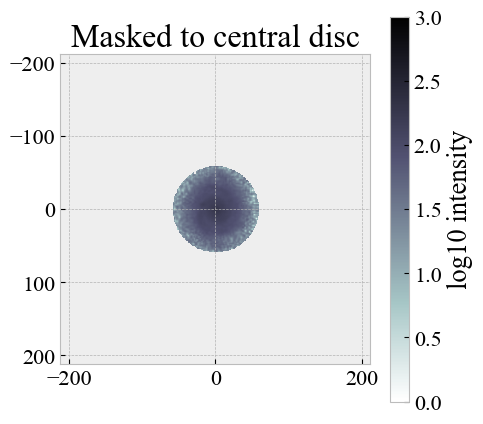

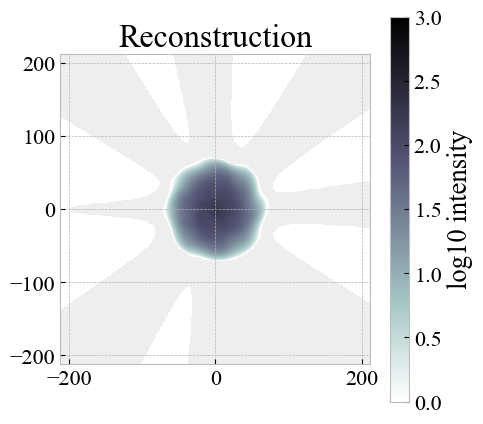

Amn (rows = n, columns = m):
[[2881.  149.   55.   10.  145.    8.   12.    8.   15.    1.    3.]
 [3025.  111.   76.   40.  166.   24.   29.   15.   78.   10.   15.]
 [2788.   88.   44.   38.  191.   54.   45.   30.   45.   23.   28.]
 [2248.  122.  246.   68.  182.   35.   30.   37.  127.   30.   33.]
 [1438.   74.  343.   68.  129.   42.   20.   35.  163.   18.   37.]
 [ 609.   84.  177.   57.  272.   39.   59.   28.  116.   63.   13.]
 [  16.   82.   47.   72.  123.   44.   43.    6.  207.   46.   23.]
 [ 152.   27.   31.   37.   83.   32.   53.   23.  144.   37.    8.]
 [ 180.   32.  118.   28.  144.   48.   37.   28.  123.   16.   14.]
 [   5.   49.   72.   27.  125.   34.   50.   21.  183.   14.    8.]]
reconimg= 646055.0
Sum= 1549047.0 (424, 424)


Processing inclinations: 100%|██████████| 30/30 [01:37<00:00,  3.26s/inclination]

0.09062339888328377 0.0014630127952642183



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=np.float64(0.045838278158139734), xmax=np.float64(0.04583827815813987), xval=0.07019136096874871). Clipping it into the allowed range.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=np.float64(0.04577116223774538), xmax=np.float64(0.04577116223774544), xval=0.09135208179379317). Clipping it into the allowed range.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/labellines/core.py:267: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=np.float64(0.04571759799432859), xmax=np.float64(0.045717597994328646), xval=0.11251280261

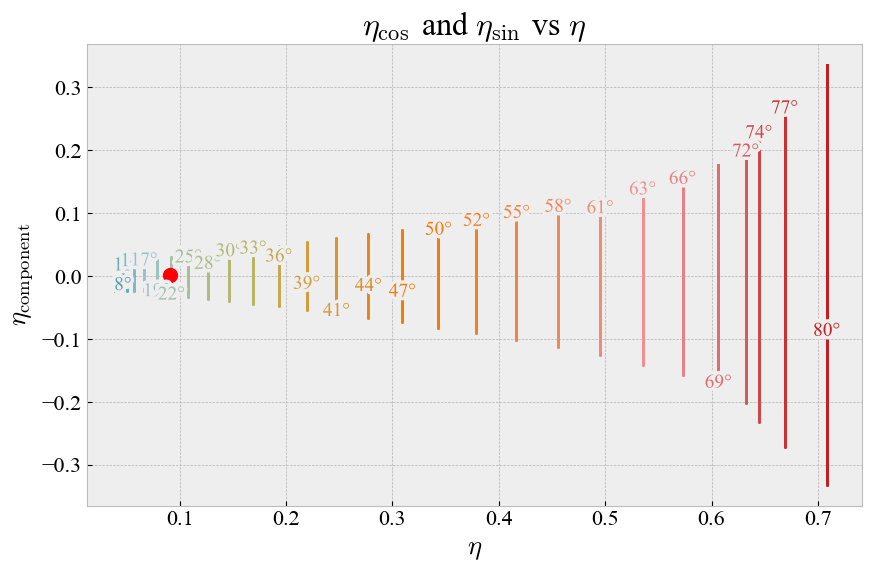

In [3]:
rmax= 212
a=5
N=100000
#Load the image as a 2D float array
file = "295140.jpg"
gray = np.array(Image.open(file).convert("L"), dtype=float)  # shape (h, w)

h, w = gray.shape
cx, cy = w//2, h//2
radius = 60  # in pixels
print(f"Image size: {w}x{h} pixels, radius={radius} pixels")
# Build the circular mask
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
x_edges = np.linspace(-rmax, rmax, w)
y_edges = np.linspace(rmax, -rmax, h)


# Apply it: keep the disc, zero (or nan) outside
disc_only = np.where(mask, gray, 0.0)

#Quick check that only the central disc remains
plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(disc_only>0, disc_only, np.nan)), extent=[x_edges[0],x_edges[-1],y_edges[0],y_edges[-1]],
           cmap='bone_r',
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Masked to central disc")
plt.show()

#feed into original DiscGalaxy pipeline
  # physical half‐width of the image
# set up your grid exactly as before:
x_edges = np.linspace(-rmax, rmax, w+1)
y_edges = np.linspace(-rmax, rmax, h+1)
x_centers = 0.5*(x_edges[:-1] + x_edges[1:])
y_centers = 0.5*(y_edges[:-1] + y_edges[1:])

D = DiscGalaxy(N=N,a=a)       # no N needed
D.img       = disc_only.T   # transpose → shape = (nx, ny)
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

# Expand & reconstruct just as you wrote originally
mmax, nmax = 10, 10
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)

# Histogram back & plot
X2, Y2   = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat   = X2.ravel();     y_flat   = Y2.ravel()
w_flat   = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)
recon_img = recon_img / np.maximum(counts, 1)
recon_img *= np.sum(disc_only) / np.sum(recon_img)
recon_img = recon_img.T

plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(recon_img>0, recon_img, np.nan)), cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Reconstruction")
plt.show()
np.set_printoptions(suppress=True) 
c1 = E1.coscoefs; s1 = E1.sincoefs
Amn = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
Amn_matrix = Amn.T 
print(f"Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 

print('reconimg=',np.sum(recon_img))
print('Sum=',np.sum(gray),gray.shape)

# the grid of inclinations to draw curves for:
incl_list = np.linspace(0, 80, 30)     # eight sample inclinations
PA_list   = np.linspace(0, 180, 18)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))

i=0
eta_avg_list=[]
for inc in tqdm(incl_list, desc="Processing inclinations", unit="inclination"):
    etas = []
    eta_cos_list = []
    eta_sin_list= []
    for PA in PA_list:
        # generate the galaxy
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        costheta = np.cos(np.radians(inc))
        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        # Compute sums
        num_cos = sum((coscoefs[2, n]) for n in range(nmax))
        num_sin = sum((sincoefs[2, n]) for n in range(nmax))
        num = sum(np.sqrt(coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax))
        denom = sum(np.sqrt(coscoefs[0, n]**2) for n in range(nmax))

        # Avoid divide-by-zero
        eta = num / denom if denom != 0 else np.nan
        eta_cos = num_cos / denom if denom != 0 else np.nan
        eta_sin = num_sin / denom if denom != 0 else np.nan

        etas.append(eta)
        eta_sin_list.append(eta_sin) 
        eta_cos_list.append(eta_cos)
    eta_avg=np.mean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(etas, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))
    #plt.plot(etas, eta_sin_list, '--', label=f"{inc:.0f}° (sin)")
    i += 1
    
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\eta_{\text{component}}$")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.title(r"$\eta_{\cos}$ and $\eta_{\sin}$ vs $\eta$")
plt.grid(True)
# now do the blind test and overplot a big marker


num_cos = sum(c1[2,n] for n in range(nmax))

num     = sum(np.hypot(c1[2,n], s1[2,n]) for n in range(nmax))
den     = sum(abs(c1[0,n])            for n in range(nmax))

eta_bt     = num/den
eta_cos_bt = num_cos/den


# big red dot
plt.plot(eta_bt, eta_cos_bt, 'o', color='red', markersize=10, label="Blind Test")
print(eta_bt, eta_cos_bt)
plt.tight_layout()
plt.show()


Fitted parameters: A=-0.40268125522788983, B=-1.800261453585805, C=0.23056376355372055, D=0.4474219249780776
0.09062339888328377


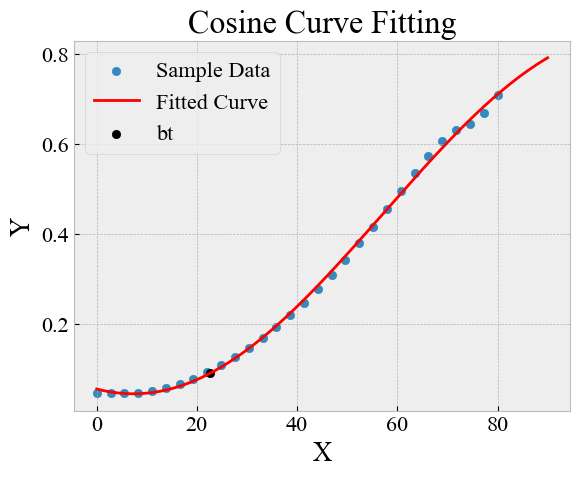

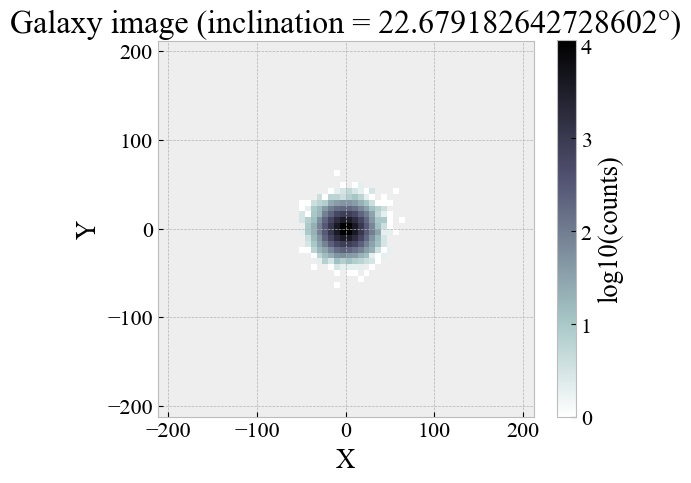

Amn inc= 80.0 (rows = n, columns = m):
[[2879.   10.   92.    5. 3924.    4.   30.    4. 3298.    4.   92.]
 [ 408.    8.   86.    7. 2281.    6.   10.    9. 2585.    6.   57.]
 [ 479.    5.   49.    2.  266.    5.   25.    6.  814.    4.   78.]
 [ 773.    5.    5.    4. 1309.    4.   16.    5. 1005.    3.   30.]
 [ 856.    5.   27.    5. 2227.    8.    6.    7. 2305.    6.   25.]
 [ 834.    5.   36.    6. 2503.    8.   17.    8. 2869.    7.   53.]
 [ 735.    4.   31.    4. 2261.    6.   22.    7. 2722.    5.   55.]
 [ 571.    2.   19.    2. 1659.    4.   18.    4. 2034.    3.   37.]
 [ 360.    1.    5.    1.  861.    2.    9.    2. 1032.    1.   10.]
 [ 119.    1.    9.    2.   12.    2.    2.    2.   57.    2.   16.]]
Amn difference (rows = n, columns = m):
[[    2.   139.   -38.     5. -3778.     4.   -17.     4. -3284.    -3.
    -89.]
 [ 2617.   103.    -9.    33. -2114.    19.    19.     7. -2507.     3.
    -41.]
 [ 2309.    83.    -5.    36.   -75.    49.    20.    24.  -769.  

Text(0.5, 1.0, 'Amn difference Simulation vs Image')

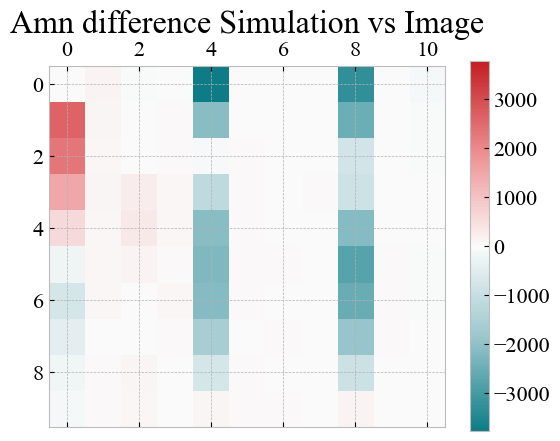

In [4]:
def cos_function(x, A, B, C, D):

    return A *np.cos(B * np.radians(x) + C) + D

# Initial guess for the parameters [A, B, C, D]
initial_guess = [70.7, 0.1, 0, 1]

# Perform the curve fitting
params, covariance = curve_fit(cos_function, incl_list, eta_avg_list, p0=initial_guess)

# Extract the fitted parameters
A_fit, B_fit, C_fit, D_fit = params

print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")
# Generate y values using the fitted parameters
inc_fit = np.linspace(0.0, 90, 500)
eta_fit = cos_function(inc_fit, A_fit, B_fit, C_fit, D_fit)


# Plot the original data and the fitted curve
plt.scatter(incl_list, eta_avg_list, label='Sample Data')
plt.plot(inc_fit, eta_fit, label='Fitted Curve', color='red')
plt.xlabel('X')
plt.ylabel('Y')


def FindInc(eta, A, B, C, D):
    inside = np.clip((eta - D) / A, -1.0, 1.0)
    theta1 = (np.arccos(inside) - C) / B
    theta2 = (-np.arccos(inside) - C) / B
    deg1 = np.rad2deg(theta1)
    deg2 = np.rad2deg(theta2)
    # Return value in [0, 90]
    valid = [deg for deg in (deg1, deg2) if 0 <= deg <= 90]
    return valid[0] if valid else np.nan  # or handle gracefully


inc_bt=FindInc(eta_bt,A_fit,B_fit,C_fit,D_fit)
print(eta_bt)
plt.scatter(inc_bt,eta_bt, color='black',label='bt')
plt.title('Cosine Curve Fitting')
plt.legend()
plt.show()


PA=0
D = DiscGalaxy(N=N, a=a, M=np.sum(gray))  # adjust N and a as needed
D.rotate_disc(inc_bt, 0, PA)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

# Replace zero pixels with NaN to avoid log10(-inf) warnings

safe_img = np.where(D.img > 0, D.img, np.nan)
log_img = np.log10(safe_img)


"""Plotting the galaxy image"""

plt.figure(figsize=(6, 5))
plt.imshow(log_img, origin='lower', cmap='bone_r',
        extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]])
plt.colorbar(label='log10(counts)')
plt.title(f"Galaxy image (inclination = {inc_bt}°)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()



E1 = D.make_expansion(mmax,nmax,a*1.5,noisy=False) # Expanding the image 
c = E1.coscoefs; s = E1.sincoefs
Amndisc = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
Amndisc_matrix = Amndisc.T 
print(f"Amn inc= {inc} (rows = n, columns = m):")
print(np.round(Amndisc_matrix,0)) 


figure = plt.figure()
axes = figure.add_subplot(111)
Amndiff=Amn_matrix-Amndisc_matrix
print("Amn difference (rows = n, columns = m):")
print(np.round(Amndiff,0))


limit=max(Amndiff.max(), -Amndiff.min())
norm = colors.TwoSlopeNorm(
    vmin=min(limit,-limit),   # most negative maps to one end
    vcenter=0,            # zero maps to center (white)
    vmax=max(limit,-limit)    # most positive maps to the other end
)

caxes = axes.matshow(Amndiff, interpolation ='nearest',norm=norm, cmap=divergent)
figure.colorbar(caxes)

axes.set_title(f"Amn difference Simulation vs Image")



Processing inclinations: 100%|██████████| 30/30 [01:32<00:00,  3.07s/inclination]


Estimated PA from real image: 148.2°


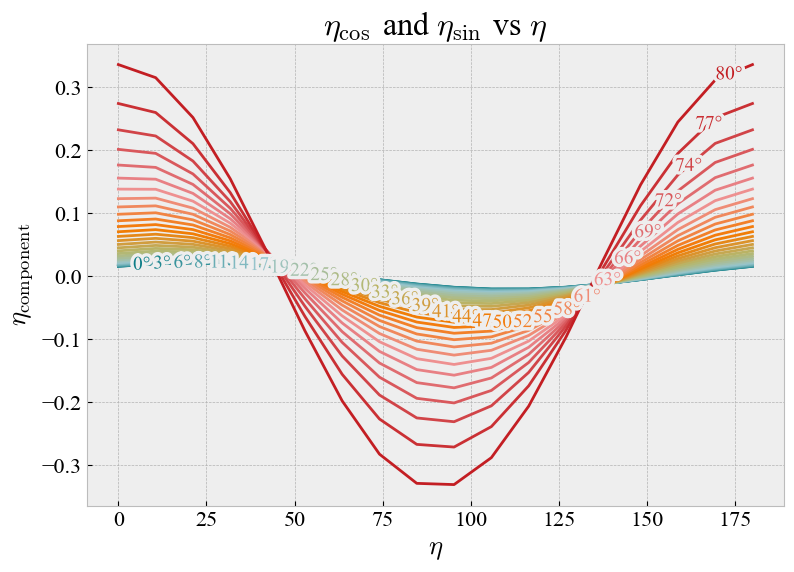

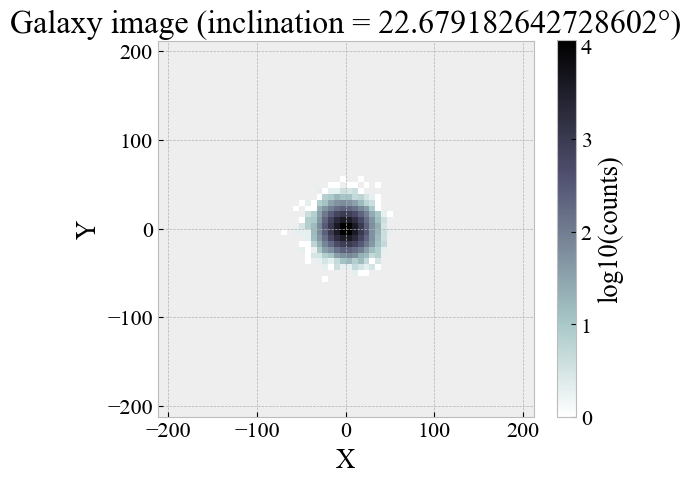

Amn inc= 80.0 (rows = n, columns = m):
[[2877.    8.  163.   17. 3926.   21.   46.   26. 3300.   23.  115.]
 [ 405.   16.   45.   14. 2267.    7.   71.    3. 2574.    7.   33.]
 [ 478.    8.   36.    3.  266.    5.   41.    7.  811.    4.   37.]
 [ 770.    3.   23.    9. 1303.    8.   11.   10. 1002.    9.   24.]
 [ 854.   11.   26.   10. 2220.    7.   52.    7. 2299.   10.   33.]
 [ 833.   15.   31.    9. 2500.    6.   76.    3. 2863.    7.   49.]
 [ 735.   14.   33.    6. 2259.    7.   78.    3. 2717.    3.   55.]
 [ 572.   10.   29.    5. 1659.    6.   62.    4. 2031.    2.   48.]
 [ 361.    5.   22.    3.  861.    4.   34.    4. 1031.    3.   32.]
 [ 119.    3.   12.    2.   14.    2.    2.    3.   55.    2.   15.]]
Amn difference (rows = n, columns = m):
[[    5.   141.  -108.    -7. -3780.   -13.   -34.   -18. -3285.   -22.
   -112.]
 [ 2620.    95.    31.    27. -2100.    17.   -42.    12. -2497.     3.
    -18.]
 [ 2310.    80.     8.    35.   -75.    49.     4.    23.  -766.  

Text(0.5, 1.0, 'Amn difference Simulation vs Image')

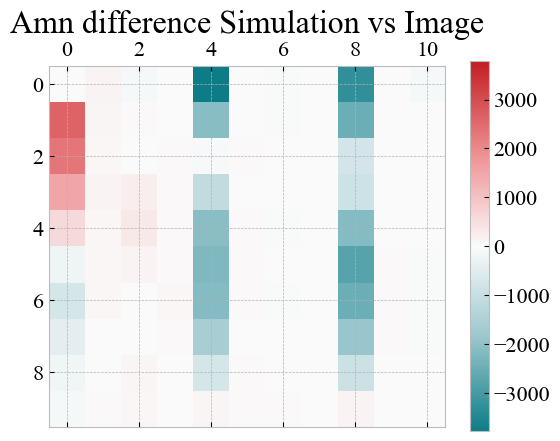

In [5]:
incl_list = np.linspace(0, 80, 30)     # eight sample inclinations
PA_list   = np.linspace(0, 180, 18)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))

i=0
eta_avg_list=[]
for inc in tqdm(incl_list, desc="Processing inclinations", unit="inclination"):
    etas = []
    eta_cos_list = []
    eta_sin_list= []
    for PA in PA_list:
        # generate the galaxy
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)

        costheta = np.cos(np.radians(inc))
        coscoefs = E.coscoefs
        sincoefs = E.sincoefs

        # Compute sums
        num_cos = sum((coscoefs[2, n]) for n in range(nmax))
        num_sin = sum((sincoefs[2, n]) for n in range(nmax))
        num = sum(np.sqrt(coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax))
        denom = sum(np.sqrt(coscoefs[0, n]**2) for n in range(nmax))

        # Avoid divide-by-zero
        eta = num / denom if denom != 0 else np.nan
        eta_cos = num_cos / denom if denom != 0 else np.nan
        eta_sin = num_sin / denom if denom != 0 else np.nan

        etas.append(eta)
        eta_sin_list.append(eta_sin) 
        eta_cos_list.append(eta_cos)
    eta_avg=np.mean(etas)
    eta_avg_list.append(eta_avg)
    plt.plot(PA_list, eta_cos_list, '-', label=f"{inc:.0f}°", color=my_gradient(colorindx[i]))
    #plt.plot(etas, eta_sin_list, '--', label=f"{inc:.0f}° (sin)")
    i += 1
# After main loop:
sim_results = {}

# Repeat just for inc_bt (fitted from your cos_function model)
eta_bt_sim = []
eta_cos_bt_sim = []
pa_bt_sim = []

for PA in PA_list:
    D = DiscGalaxy(N=N, a=a, M=np.sum(gray))
    D.rotate_disc(inc_bt, 0, PA)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    E = D.make_pointexpansion(mmax, nmax, a)

    coscoefs = E.coscoefs
    sincoefs = E.sincoefs

    num_cos = sum((coscoefs[2, n]) for n in range(nmax))
    num     = sum(np.sqrt(coscoefs[2, n]**2 + sincoefs[2, n]**2) for n in range(nmax))
    denom   = sum(np.abs(coscoefs[0, n]) for n in range(nmax))

    eta     = num / denom if denom != 0 else np.nan
    eta_cos = num_cos / denom if denom != 0 else np.nan

    eta_bt_sim.append(eta)
    eta_cos_bt_sim.append(eta_cos)
    pa_bt_sim.append(PA)

# Now: match blind test (η_bt, η_cos_bt) to closest point
eta_bt_sim = np.array(eta_bt_sim)
eta_cos_bt_sim = np.array(eta_cos_bt_sim)
pa_bt_sim = np.array(pa_bt_sim)

dist = np.sqrt((eta_bt_sim - eta_bt)**2 + (eta_cos_bt_sim - eta_cos_bt)**2)
best_idx = np.argmin(dist)
best_PA = pa_bt_sim[best_idx]
print(f"Estimated PA from real image: {best_PA:.1f}°")
    
plt.xlabel(r"$\eta$")
plt.ylabel(r"$\eta_{\text{component}}$")
labelLines(plt.gca().get_lines(),align=False,fontsize=14)
plt.title(r"$\eta_{\cos}$ and $\eta_{\sin}$ vs $\eta$")
plt.grid(True)


D = DiscGalaxy(N=N, a=a, M=np.sum(gray))  # adjust N and a as needed
D.rotate_disc(inc_bt, 0, best_PA)
D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
img_orig = D.img.copy()

# Replace zero pixels with NaN to avoid log10(-inf) warnings

safe_img = np.where(D.img > 0, D.img, np.nan)
log_img = np.log10(safe_img)


"""Plotting the galaxy image"""

plt.figure(figsize=(6, 5))
plt.imshow(log_img, origin='lower', cmap='bone_r',
        extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]])
plt.colorbar(label='log10(counts)')
plt.title(f"Galaxy image (inclination = {inc_bt}°)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()



E1 = D.make_expansion(mmax,nmax,a*1.5,noisy=False) # Expanding the image 
c = E1.coscoefs; s = E1.sincoefs
Amndisc = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
Amndisc_matrix = Amndisc.T 
print(f"Amn inc= {inc} (rows = n, columns = m):")
print(np.round(Amndisc_matrix,0)) 


figure = plt.figure()
axes = figure.add_subplot(111)
Amndiff=Amn_matrix-Amndisc_matrix
print("Amn difference (rows = n, columns = m):")
print(np.round(Amndiff,0))


limit=max(Amndiff.max(), -Amndiff.min())
norm = colors.TwoSlopeNorm(
    vmin=min(limit,-limit),   # most negative maps to one end
    vcenter=0,            # zero maps to center (white)
    vmax=max(limit,-limit)    # most positive maps to the other end
)

caxes = axes.matshow(Amndiff, interpolation ='nearest',norm=norm, cmap=divergent)
figure.colorbar(caxes)

axes.set_title(f"Amn difference Simulation vs Image")



Image size: 424x424 pixels, radius=65 pixels


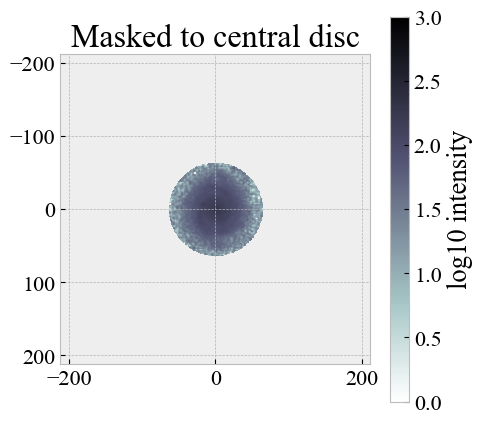

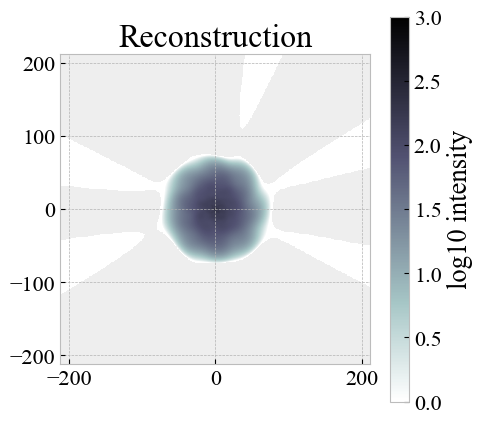

Amn (rows = n, columns = m):
[[2881.  149.   55.   10.  145.    8.   12.    8.   15.    1.    3.]
 [3025.  111.   76.   40.  166.   24.   29.   15.   78.   10.   15.]
 [2790.   87.   45.   38.  191.   54.   45.   30.   45.   23.   28.]
 [2260.  120.  248.   68.  181.   34.   29.   37.  127.   31.   34.]
 [1483.   71.  349.   69.  138.   43.   14.   31.  162.   19.   38.]
 [ 721.   75.  192.   62.  260.   51.   48.   15.  114.   65.   27.]
 [ 200.   72.   55.   80.  148.   64.   22.   19.  204.   49.   44.]
 [  20.   38.   42.   27.   51.   23.   62.   38.  152.   34.   22.]
 [ 159.   25.  119.   26.  147.   48.   39.   32.  122.   15.   13.]
 [ 141.   41.   89.   19.  142.   15.   52.   36.  185.   13.   20.]]
reconimg= 679775.0000000001
Sum= 1549047.0 (424, 424)


Building η(inc) grid:   0%|          | 0/30 [00:05<?, ?it/s]


KeyboardInterrupt: 

<Figure size 900x600 with 0 Axes>

In [5]:
rmax= 212
a=5
N=100000
#Load the image as a 2D float array
file = "295140.jpg"
gray = np.array(Image.open(file).convert("L"), dtype=float)  # shape (h, w)

h, w = gray.shape
cx, cy = w//2, h//2
radius = 65  # in pixels
print(f"Image size: {w}x{h} pixels, radius={radius} pixels")
# Build the circular mask
y, x = np.indices((h,w))
mask = (x - cx)**2 + (y - cy)**2 <= radius**2
x_edges = np.linspace(-rmax, rmax, w)
y_edges = np.linspace(rmax, -rmax, h)


# Apply it: keep the disc, zero (or nan) outside
disc_only = np.where(mask, gray, 0.0)

#Quick check that only the central disc remains
plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(disc_only>0, disc_only, np.nan)), extent=[x_edges[0],x_edges[-1],y_edges[0],y_edges[-1]],
           cmap='bone_r',
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Masked to central disc")
plt.show()

#feed into original DiscGalaxy pipeline
  # physical half‐width of the image
# set up your grid exactly as before:
x_edges = np.linspace(-rmax, rmax, w+1)
y_edges = np.linspace(-rmax, rmax, h+1)
x_centers = 0.5*(x_edges[:-1] + x_edges[1:])
y_centers = 0.5*(y_edges[:-1] + y_edges[1:])

D = DiscGalaxy(N=N,a=a)       # no N needed
D.img       = disc_only.T   # transpose → shape = (nx, ny)
D.x_edges   = x_edges
D.y_edges   = y_edges
D.x_centers = x_centers
D.y_centers = y_centers

# Expand & reconstruct just as you wrote originally
mmax, nmax = 10, 10
E1 = D.make_expansion(mmax, nmax, a, noisy=False)
E1.laguerre_reconstruction(D.r, D.p)

# Histogram back & plot
X2, Y2   = np.meshgrid(x_centers, y_centers, indexing='ij')
x_flat   = X2.ravel();     y_flat   = Y2.ravel()
w_flat   = E1.reconstruction.ravel()

recon_img, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges],
    weights=w_flat
)
counts, _, _ = np.histogram2d(
    x_flat, y_flat,
    bins=[x_edges, y_edges]
)
recon_img = recon_img / np.maximum(counts, 1)
recon_img *= np.sum(disc_only) / np.sum(recon_img)
recon_img = recon_img.T

plt.figure(figsize=(5,5))
plt.imshow(np.log10(np.where(recon_img>0, recon_img, np.nan)), cmap='bone_r',
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
           vmin=0, vmax=3)
plt.colorbar(label='log10 intensity')
plt.title("Reconstruction")
plt.show()
np.set_printoptions(suppress=True) 
c1 = E1.coscoefs; s1 = E1.sincoefs
Amn = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
Amn_matrix = Amn.T 
print(f"Amn (rows = n, columns = m):")
print(np.round(Amn_matrix,0)) 

print('reconimg=',np.sum(recon_img))
print('Sum=',np.sum(gray),gray.shape)

# the grid of inclinations to draw curves for:
incl_list = np.linspace(0, 80, 30)     # eight sample inclinations
PA_list   = np.linspace(0, 360, 45)     # fine PA sampling
colorindx = np.linspace(0, 1, len(incl_list+1))  # color index for inclinations
plt.figure(figsize=(9, 6))


incl_list = np.linspace(0, 80, 30)    # 30 inclinations
PA_list   = np.linspace(0, 360, 45)   # 45 PAs

# will hold for each inclination the array of η over all PAs
etas_vs_PA = []

for inc in tqdm(incl_list, desc="Building η(inc) grid"):
    etas_this_inc = []
    for PA in PA_list:
        D = DiscGalaxy(N=N, a=a, M=np.sum(gray))  # adjust N and a as needed
        D.rotate_disc(inc, 0, PA)
        D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
        E = D.make_pointexpansion(mmax, nmax, a)
        c,s = E.coscoefs, E.sincoefs

        num = sum(np.hypot(c[2,n], s[2,n]) for n in range(nmax))
        den = sum(abs(c[0,n])            for n in range(nmax))
        eta = num/den if den else np.nan

        etas_this_inc.append(eta)
    etas_vs_PA.append(etas_this_inc)

etas_vs_PA = np.array(etas_vs_PA)   # shape = (30,45)

# 2) collapse out PA to get ⟨η⟩(inc):
eta_means = np.nanmean(etas_vs_PA, axis=1)

# optional sanity‐check plot
plt.figure()
plt.plot(incl_list, eta_means, 'o-')
plt.xlabel("inclination [°]")
plt.ylabel("mean η")
plt.title("Mean η vs true inclination")
plt.grid(True)
plt.show()

# 3) build the inverse map inc = f⁻¹(η):
inc_from_eta = interp1d(eta_means, incl_list,
                        kind='cubic',
                        bounds_error=False,
                        fill_value='extrapolate')

# 4) measure (η,η_sin) on your blind test image:
#    (you already have c1,s1,den from your reconstruction of the real galaxy)
Num_cos = sum(c1[2,n] for n in range(nmax))
Num_sin = sum(s1[2,n] for n in range(nmax))
den     = sum(abs(c1[0,n])  for n in range(nmax))

eta_bt     = np.hypot(Num_cos, Num_sin) / den
sin2PA_bt  = Num_sin / (den * eta_bt)
cos2PA_bt  = Num_cos / (den * eta_bt)

# invert η→incl:
inc_bt = float(inc_from_eta(eta_bt))

# recover PA:
PA_bt  = 0.5 * np.degrees(np.arctan2(sin2PA_bt, cos2PA_bt))
PA_bt %= 180.0

print(f"Blind‑test:  η = {eta_bt:.4f}")
print(f" → inferred inclination = {inc_bt:.1f}°")
print(f" → inferred PA          = {PA_bt:.1f}°")

# 5) regenerate a “perfect” disk at (inc_bt,PA_bt) and compare Amn matrices
D2 = DiscGalaxy(N=N, a=a, M=np.sum(gray))
D2.rotate_disc(inc_bt, 0, PA_bt)
D2.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.0)
E2 = D2.make_expansion(mmax, nmax, a, noisy=False)

Amn_true = np.sqrt(c1**2 + s1**2).T
Amn_sim  = np.sqrt(E2.coscoefs**2 + E2.sincoefs**2).T

diff = Amn_true - Amn_sim

# visualize
plt.figure(figsize=(6,5))
plt.imshow(diff, origin='lower', 
           cmap='RdBu_r', 
           interpolation='nearest',
           extent=[0, mmax, 0, nmax],
           vmin=-np.max(np.abs(diff)), 
           vmax= np.max(np.abs(diff)))
plt.colorbar(label="Amn_true – Amn_sim")
plt.xlabel("m")
plt.ylabel("n")
plt.title(f"Amn difference at inc={inc_bt:.1f}°, PA={PA_bt:.1f}°")
plt.show()

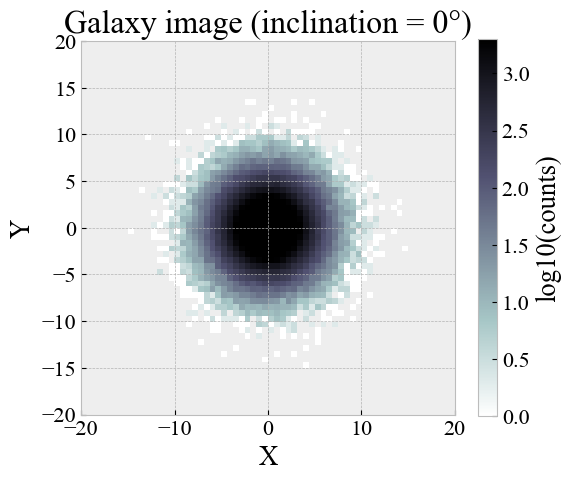

Amn inc= 0 (rows = n, columns = m):
[[0.153 0.001 0.    0.    0.    0.    0.001]
 [0.043 0.    0.    0.    0.    0.    0.   ]
 [0.01  0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


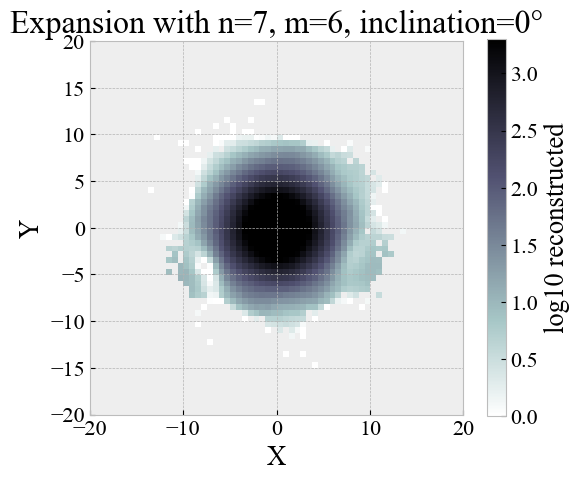

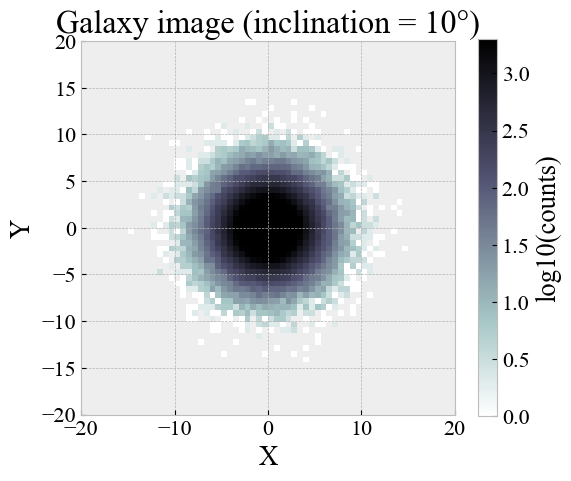

Amn inc= 10 (rows = n, columns = m):
[[0.154 0.001 0.001 0.    0.    0.    0.001]
 [0.044 0.    0.    0.    0.    0.    0.   ]
 [0.011 0.001 0.    0.    0.    0.    0.   ]
 [0.002 0.001 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


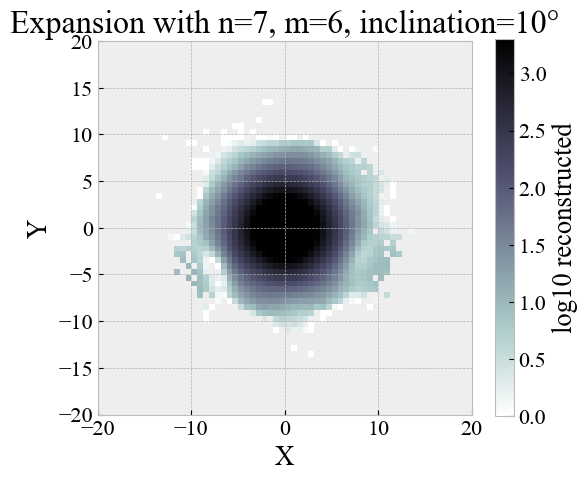

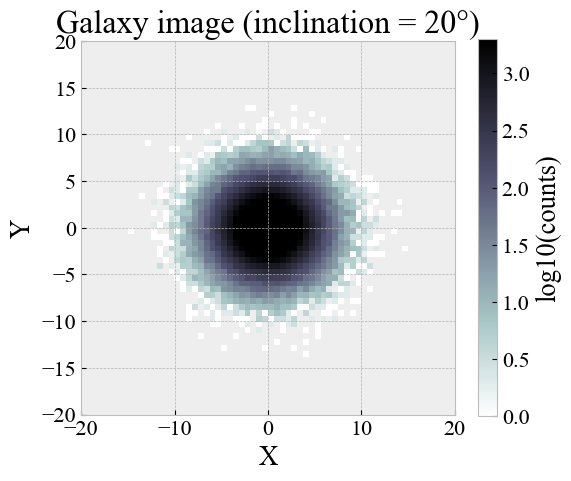

Amn inc= 20 (rows = n, columns = m):
[[0.156 0.001 0.006 0.    0.    0.    0.001]
 [0.047 0.    0.002 0.    0.    0.    0.   ]
 [0.012 0.001 0.001 0.    0.    0.    0.   ]
 [0.003 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


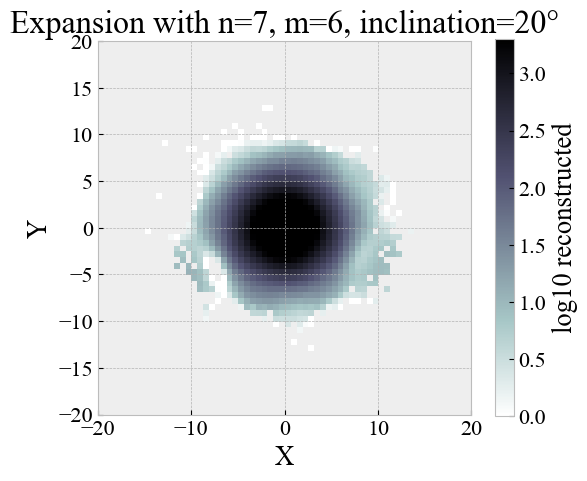

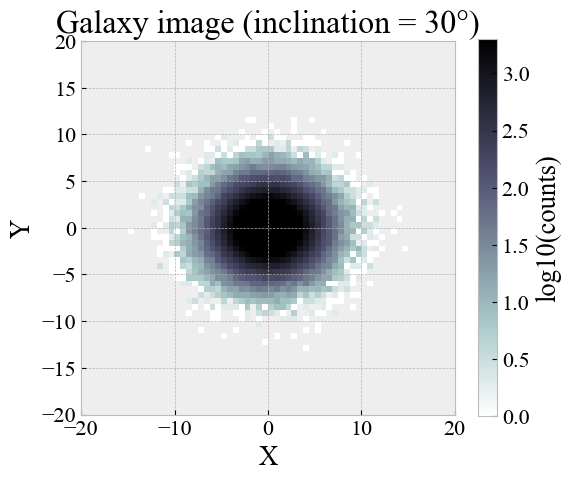

Amn inc= 30 (rows = n, columns = m):
[[0.161 0.001 0.014 0.    0.001 0.    0.001]
 [0.053 0.    0.003 0.    0.001 0.    0.   ]
 [0.015 0.001 0.003 0.    0.    0.    0.   ]
 [0.004 0.001 0.001 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]]


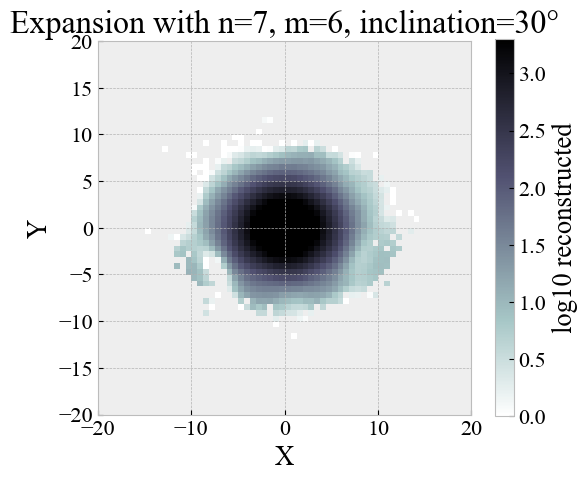

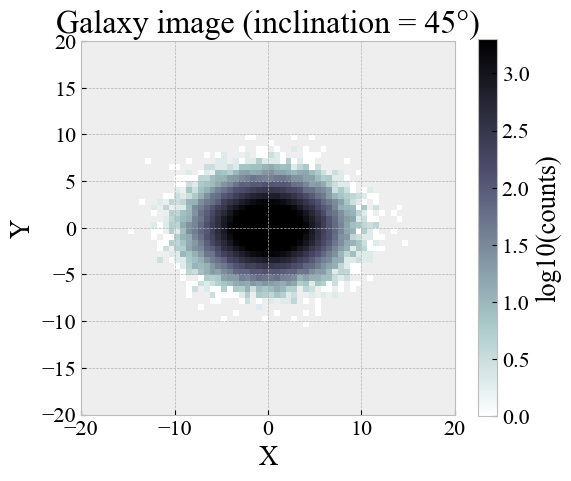

Amn inc= 45 (rows = n, columns = m):
[[0.172 0.001 0.038 0.    0.005 0.    0.001]
 [0.068 0.001 0.004 0.    0.002 0.    0.   ]
 [0.024 0.001 0.008 0.    0.001 0.    0.   ]
 [0.008 0.001 0.005 0.    0.    0.    0.   ]
 [0.003 0.001 0.002 0.    0.    0.    0.   ]
 [0.001 0.    0.001 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


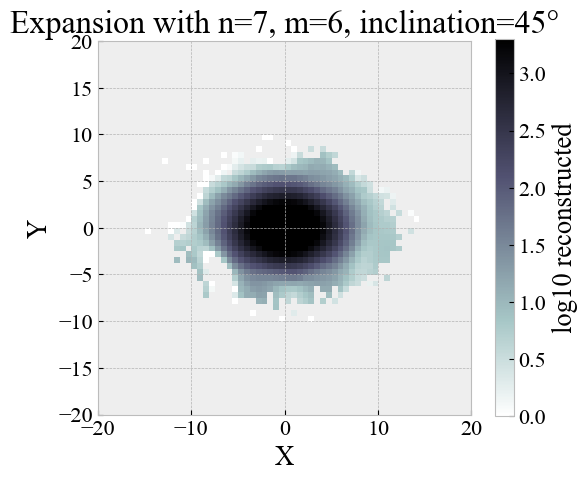

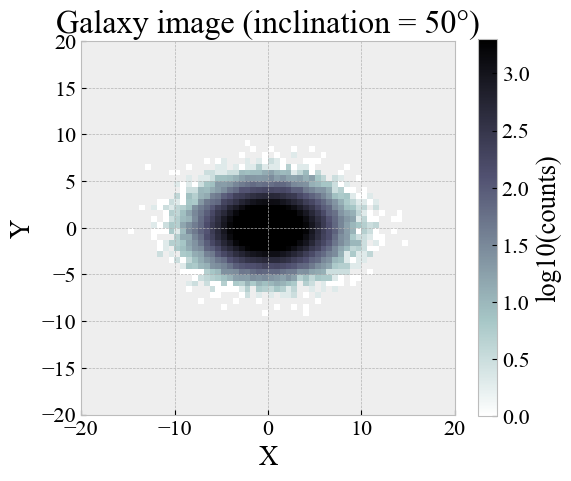

Amn inc= 50 (rows = n, columns = m):
[[0.177 0.001 0.05  0.    0.008 0.    0.002]
 [0.075 0.001 0.003 0.    0.003 0.    0.001]
 [0.029 0.001 0.01  0.    0.002 0.    0.   ]
 [0.011 0.001 0.007 0.    0.001 0.    0.   ]
 [0.004 0.001 0.003 0.    0.    0.    0.   ]
 [0.001 0.    0.002 0.    0.    0.    0.   ]
 [0.    0.    0.001 0.    0.    0.    0.   ]]


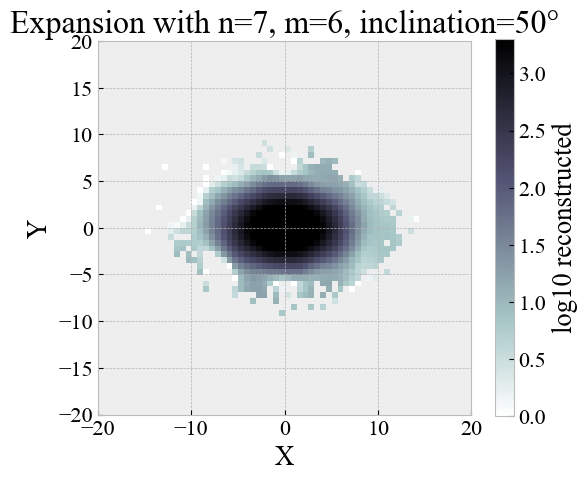

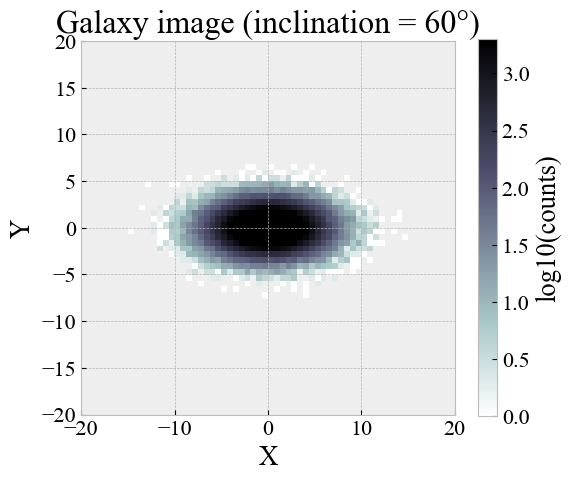

Amn inc= 60 (rows = n, columns = m):
[[0.188 0.001 0.086 0.    0.022 0.001 0.006]
 [0.092 0.001 0.004 0.    0.006 0.    0.003]
 [0.042 0.001 0.014 0.    0.006 0.    0.001]
 [0.02  0.001 0.012 0.    0.003 0.    0.   ]
 [0.009 0.001 0.008 0.    0.001 0.    0.   ]
 [0.004 0.001 0.005 0.    0.    0.    0.   ]
 [0.002 0.    0.003 0.    0.    0.    0.   ]]


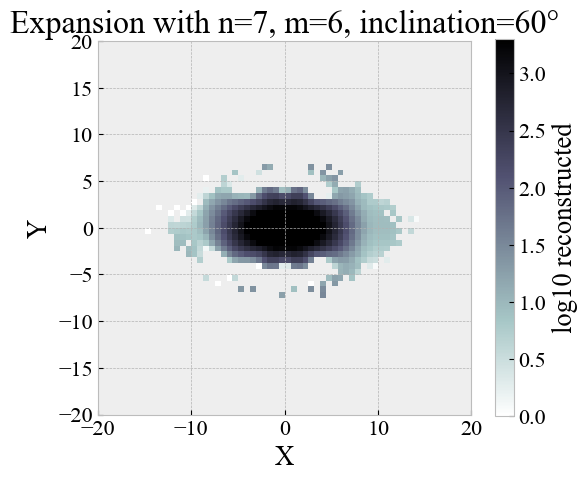

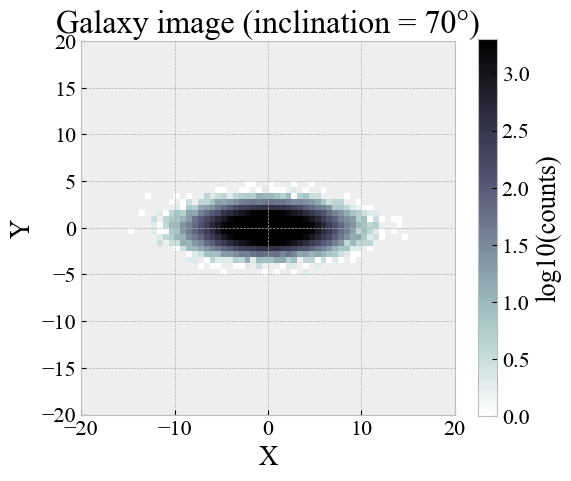

Amn inc= 70 (rows = n, columns = m):
[[0.202 0.001 0.146 0.    0.057 0.001 0.023]
 [0.115 0.001 0.029 0.    0.004 0.    0.006]
 [0.064 0.001 0.01  0.    0.013 0.    0.007]
 [0.037 0.001 0.017 0.001 0.01  0.    0.003]
 [0.022 0.001 0.016 0.    0.005 0.    0.001]
 [0.013 0.001 0.012 0.    0.003 0.    0.   ]
 [0.008 0.001 0.008 0.    0.001 0.    0.   ]]


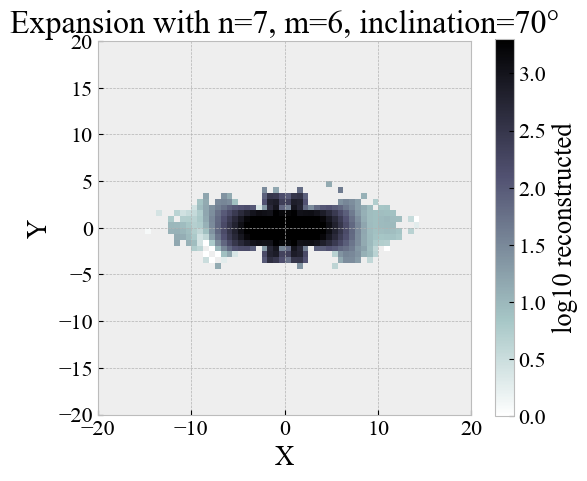

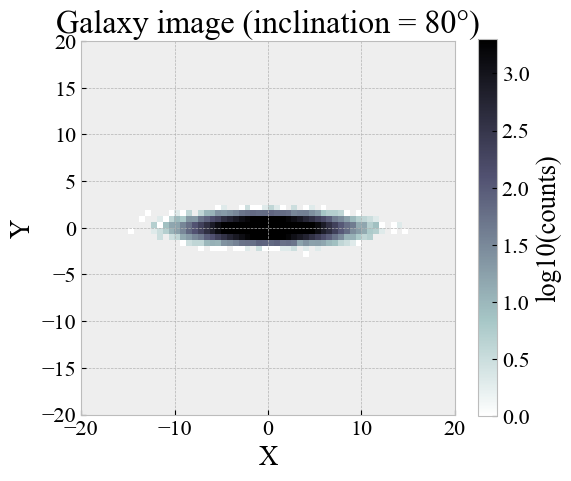

Amn inc= 80 (rows = n, columns = m):
[[0.215 0.001 0.25  0.001 0.151 0.    0.094]
 [0.142 0.001 0.102 0.    0.034 0.    0.007]
 [0.096 0.001 0.032 0.    0.008 0.001 0.016]
 [0.069 0.001 0.001 0.001 0.019 0.001 0.017]
 [0.051 0.001 0.011 0.001 0.018 0.    0.012]
 [0.039 0.001 0.016 0.001 0.015 0.    0.008]
 [0.03  0.001 0.017 0.    0.011 0.    0.004]]


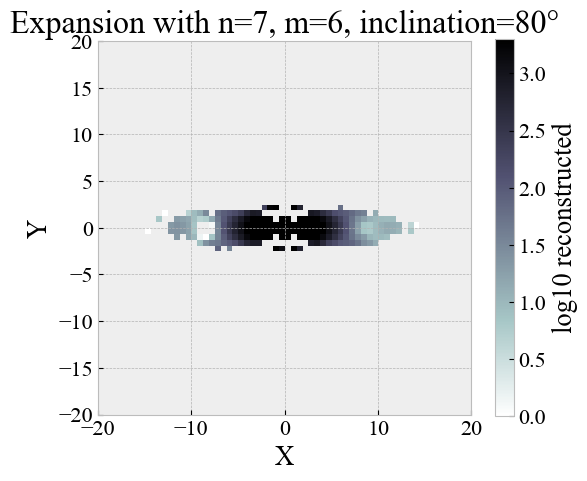

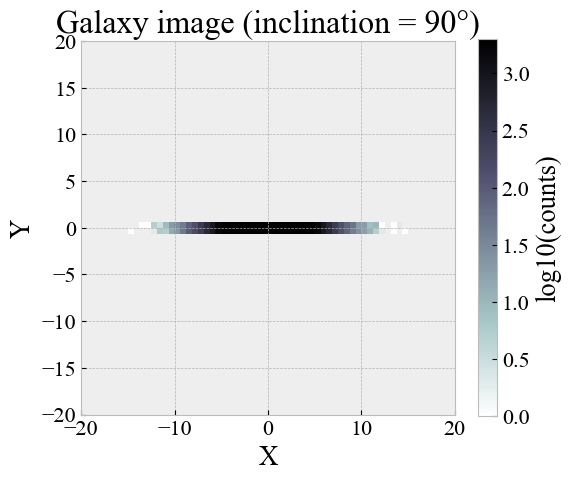

Amn inc= 90 (rows = n, columns = m):
[[0.224 0.    0.449 0.    0.449 0.    0.449]
 [0.163 0.    0.325 0.    0.325 0.    0.325]
 [0.126 0.    0.252 0.    0.252 0.    0.252]
 [0.106 0.001 0.211 0.001 0.211 0.001 0.211]
 [0.093 0.001 0.186 0.001 0.186 0.001 0.186]
 [0.084 0.001 0.168 0.001 0.168 0.001 0.168]
 [0.077 0.    0.155 0.    0.155 0.    0.155]]


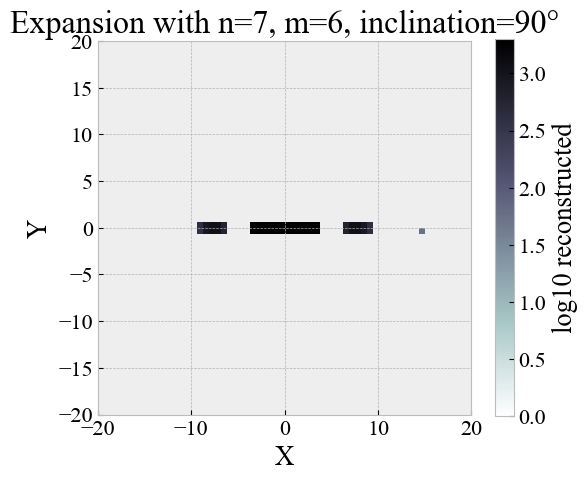

In [ ]:
rmax=20

inc = [0,10,20,30,45,50,60,70,80,90] # degrees, change as needed

for inc in inc:
    """Generating the galaxy image with the specified inclination"""
    D = DiscGalaxy(N=N, a=a)  # adjust N and a as needed
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()

    # Replace zero pixels with NaN to avoid log10(-inf) warnings

    safe_img = np.where(D.img > 0, D.img, np.nan)
    log_img = np.log10(safe_img)


    """Plotting the galaxy image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_img, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10(counts)')
    plt.title(f"Galaxy image (inclination = {inc}°)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()


    m,n=6,7 #Toggle this to see the expansion coefficients and how they change, goal: find the closest match to the image

    E1 = D.make_pointexpansion(m,n,a*1.5,noisy=False) # Expanding the image 
    c = E1.coscoefs; s = E1.sincoefs
    Amn = np.sqrt(E1.coscoefs**2 +E1.sincoefs**2) 
    Amn_matrix = Amn.T 
    print(f"Amn inc= {inc} (rows = n, columns = m):")
    print(np.round(Amn_matrix,3)) 
    
    """Reconstruct an image from the expansion coefficients"""

    E1.laguerre_reconstruction(D.r,D.p)

    x , y= D.r * np.cos(D.p), D.r * np.sin(D.p) # Convert polar coordinates to Cartesian coordinates

    bins = [D.x_edges, D.y_edges]

    recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
    counts, _, _ = np.histogram2d(x, y, bins=bins)
    recon_img /= np.maximum(counts, 1)
    recon_img *= np.sum(img_orig) / np.sum(recon_img)
    recon_img = recon_img.T

    safe_recon = np.where(recon_img > 0, recon_img, np.nan)
    log_recon = np.log10(safe_recon)

    """Plotting the reconstructed image"""

    plt.figure(figsize=(6, 5))
    plt.imshow(log_recon, origin='lower', cmap='bone_r',
            extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],
            vmin=0., vmax=3.3)
    plt.colorbar(label='log10 reconstructed')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Expansion with n={n}, m={m}, inclination={inc}°')
    plt.tight_layout()
    plt.show()

  


In [ ]:
"""Saving the images and Amn matrices for different inclinations for Sonification video"""

inc_list = [0,10,20,30,45,50,60,70,80,90]
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

for inc in inc_list:
    # — Generate the galaxy & log image —
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=noise)
    img_orig = D.img.copy()
    safe_img = np.where(D.img > 0, D.img, np.nan)
    log_img  = np.log10(safe_img)

    # — Save the original log-image —
    fig = plt.figure(figsize=(6,5))
    plt.imshow(log_img, origin='lower', cmap='bone_r',
               extent=[D.x_edges[0], D.x_edges[-1],
                       D.y_edges[0], D.y_edges[-1]],
               vmin=0., vmax=3.3)
    plt.colorbar(label='log10(counts)')
    plt.title(f"Galaxy (inc={inc}°)")
    plt.xlabel("X"); plt.ylabel("Y")
    
    plt.tight_layout()
    fn1 = os.path.join(output_dir, f"galaxy_inc{inc:02d}_orig.png")
    plt.savefig(fn1, dpi=300)
    plt.close(fig)

    # — Compute & save the Amn matrix —
    m, n = 6, 7
    E1 = D.make_pointexpansion(m, n, a*1.5, noisy=False)
    Amn_matrix = np.sqrt(E1.coscoefs**2 + E1.sincoefs**2).T
    # save as text (tab- or comma-delimited)
    fn_npy = os.path.join(output_dir, f"Amn_inc{inc:02d}.npy")
    np.save(fn_npy, Amn_matrix)
    print(f"Saved Amn matrix for inc={inc}° to {fn_npy}")

    print(f"Saved Amn matrix for inc={inc}° to {fn_npy}")

    # — Reconstruct & save the reconstructed log-image —
    E1.laguerre_reconstruction(D.r, D.p)
    x, y = D.r*np.cos(D.p), D.r*np.sin(D.p)
    bins = [D.x_edges, D.y_edges]
    recon_img, _, _ = np.histogram2d(x, y, bins=bins, weights=E1.reconstruction)
    counts,    _, _ = np.histogram2d(x, y, bins=bins)
    recon_img /= np.maximum(counts, 1)
    recon_img *= np.sum(img_orig) / np.sum(recon_img)
    recon_img = recon_img.T
    safe_recon = np.where(recon_img > 0, recon_img, np.nan)
    log_recon  = np.log10(safe_recon)

    fig = plt.figure(figsize=(6,5))
    plt.imshow(log_recon, origin='lower', cmap='bone_r',
               extent=[D.x_edges[0], D.x_edges[-1],
                       D.y_edges[0], D.y_edges[-1]],
               vmin=0., vmax=3.3)
    plt.colorbar(label='log10 reconstructed')
    plt.title(f"Reconstruction (inc={inc}°)")
    plt.xlabel("X"); plt.ylabel("Y")
    plt.tight_layout()
    fn3 = os.path.join(output_dir, f"galaxy_inc{inc:02d}_recon.png")
    plt.savefig(fn3, dpi=300)
    plt.close(fig)


Saved Amn matrix for inc=0° to outputs/Amn_inc00.npy
Saved Amn matrix for inc=0° to outputs/Amn_inc00.npy
Saved Amn matrix for inc=10° to outputs/Amn_inc10.npy
Saved Amn matrix for inc=10° to outputs/Amn_inc10.npy
Saved Amn matrix for inc=20° to outputs/Amn_inc20.npy
Saved Amn matrix for inc=20° to outputs/Amn_inc20.npy
Saved Amn matrix for inc=30° to outputs/Amn_inc30.npy
Saved Amn matrix for inc=30° to outputs/Amn_inc30.npy
Saved Amn matrix for inc=45° to outputs/Amn_inc45.npy
Saved Amn matrix for inc=45° to outputs/Amn_inc45.npy
Saved Amn matrix for inc=50° to outputs/Amn_inc50.npy
Saved Amn matrix for inc=50° to outputs/Amn_inc50.npy
Saved Amn matrix for inc=60° to outputs/Amn_inc60.npy
Saved Amn matrix for inc=60° to outputs/Amn_inc60.npy
Saved Amn matrix for inc=70° to outputs/Amn_inc70.npy
Saved Amn matrix for inc=70° to outputs/Amn_inc70.npy
Saved Amn matrix for inc=80° to outputs/Amn_inc80.npy
Saved Amn matrix for inc=80° to outputs/Amn_inc80.npy
Saved Amn matrix for inc=90° t